In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])  # trainset을 trainset과 valset으로 분할
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


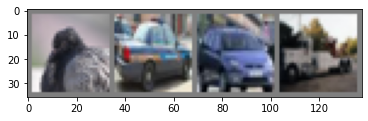

bird  car   car   truck
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4])
tensor([2, 1, 1, 9])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(type(images), images.shape)
print(type(labels), labels.shape)
print(labels)

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act

        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()

        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        if self.act ==  'relu':
            self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)

        return x

In [5]:
net = MLP(3072, 10, 100, 4, 'relu')
print(net)
print(sum(p.numel() for p in net.parameters()))

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)
338610


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        inputs = inputs.view(-1, 3*32*32)   # parameter와의 행렬곱을 위해 shape을 조정함
                                            # inputs:(4, 3072), weights:(100, 3072) -> matmmul()과정에서 weight를 transpose()한다
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.203
[1,  4000] loss: 1.891
[1,  6000] loss: 1.768
[1,  8000] loss: 1.703
[1, 10000] loss: 1.648
[2,  2000] loss: 1.594
[2,  4000] loss: 1.555
[2,  6000] loss: 1.551
[2,  8000] loss: 1.526
[2, 10000] loss: 1.514
Finished Training


In [ ]:
PATH = './model_state/cifar_net.pth'
torch.save(net.state_dict(), PATH)

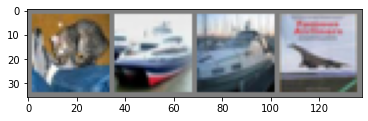

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        images = images.view(-1, 3*32*32)
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 46 %


In [ ]:
correct = 0
total = 0
val_loss = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in valloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        images = images.view(-1, 3*32*32)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss

        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)

acc = correct / total * 100
print('Accuracy of the network on the 10000 test images: {:2.2f}%   Loss: {:2.5f}'.format(acc, val_loss))

Accuracy of the network on the 10000 test images: 45.24%   Loss: 1.52742


In [25]:
def experiment(args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)

    for epoch in range(args.epoch):   # 데이터셋을 수차례 반복합니다.

        # ===== Trainning ===== #
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
            inputs, labels = data

            # 변화도(Gradient) 매개변수를 0으로 만들고
            optimizer.zero_grad()

            # 순전파 + 역전파 + 최적화를 한 후
            inputs = inputs.view(-1, 3*32*32)   # parameter와의 행렬곱을 위해 shape을 조정함
                                                # inputs:(4, 3072), weights:(100, 3072) -> matmmul()과정에서 weight를 transpose()한다
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 통계를 출력합니다.
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

        # ===== Validation ===== #
        correct = 0
        total = 0
        val_loss = 0
        # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                # 신경망에 이미지를 통과시켜 출력을 계산합니다
                images = images.view(-1, 3*32*32)
                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss += loss

                # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss /= len(valloader)
            val_acc = correct / total * 100

        print('Epoch: {:2d}  Train Loss: {:3.5f}  Val Loss: {:3.5f}  Val Accuracy: {:2.3f}'.format(epoch, running_loss, val_loss, val_acc))

    # ===== Testing ===== #
    correct = 0
    total = 0
    # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # 신경망에 이미지를 통과시켜 출력을 계산합니다
            images = images.view(-1, 3*32*32)
            outputs = net(images)
            # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = correct / total * 100
    return 'in_dim: {:2d}  out_dim: {:2d}  hid_dim: {:3d}  n_layer: {:3d}  act: {}  Test Accuracy: {:2.3f}'.format(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, test_acc)

In [26]:
import argparse

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'
args.lr = 0.001
args.mm = 0.9
args.epoch = 2

list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print(result)


[1,  2000] loss: 2.186
[1,  4000] loss: 1.887
[1,  6000] loss: 1.776
[1,  8000] loss: 1.714
[1, 10000] loss: 1.697
Epoch:  0  Train Loss: 0.00000  Val Loss: 1.65797  Val Accuracy: 40.870
[2,  2000] loss: 1.633
[2,  4000] loss: 1.599
[2,  6000] loss: 1.586
[2,  8000] loss: 1.585
[2, 10000] loss: 1.563
Epoch:  1  Train Loss: 0.00000  Val Loss: 1.57945  Val Accuracy: 42.800
in_dim: 3072  out_dim: 10  hid_dim:  50  n_layer:   4  act: relu  Test Accuracy: 43.770
[1,  2000] loss: 2.219
[1,  4000] loss: 1.941
[1,  6000] loss: 1.769
[1,  8000] loss: 1.718
[1, 10000] loss: 1.665
Epoch:  0  Train Loss: 0.00000  Val Loss: 1.65929  Val Accuracy: 40.780
[2,  2000] loss: 1.611
[2,  4000] loss: 1.567
[2,  6000] loss: 1.539
[2,  8000] loss: 1.543
[2, 10000] loss: 1.526
Epoch:  1  Train Loss: 0.00000  Val Loss: 1.53636  Val Accuracy: 45.460
in_dim: 3072  out_dim: 10  hid_dim: 100  n_layer:   4  act: relu  Test Accuracy: 46.770
[1,  2000] loss: 2.183
[1,  4000] loss: 1.883
[1,  6000] loss: 1.747
[1,  80